In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

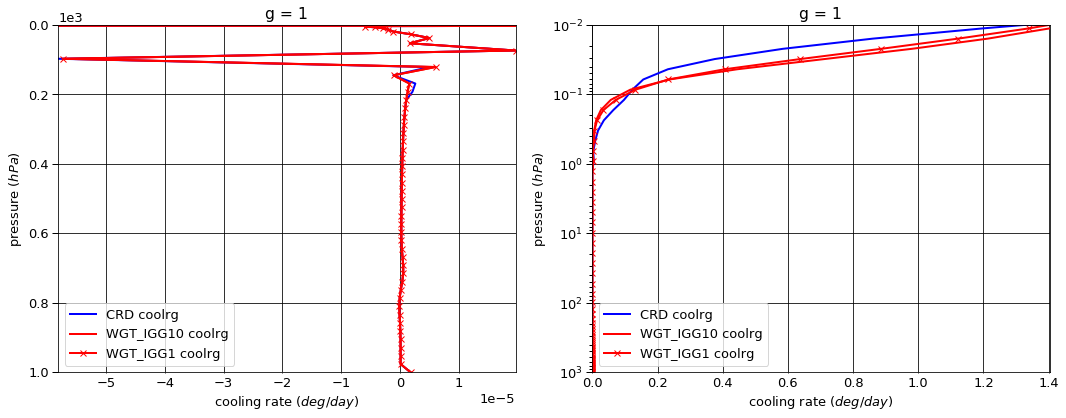

# Figure: cooling rate g-group 2

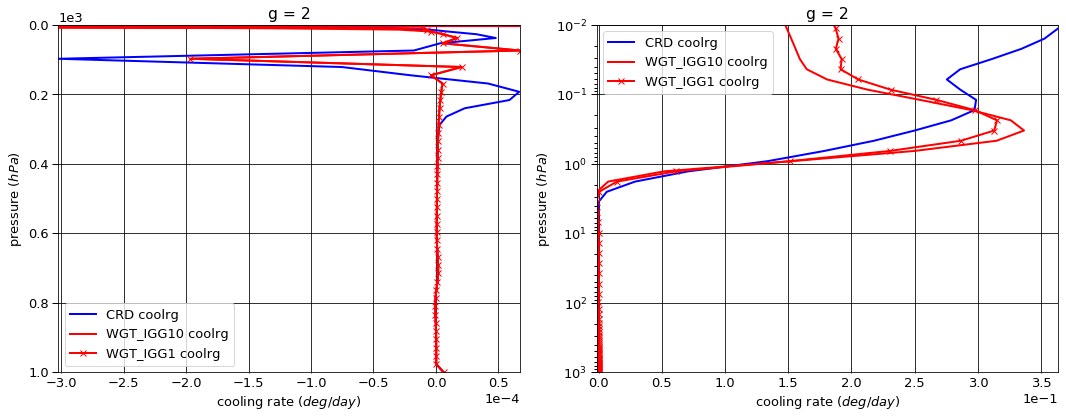

# Figure: cooling rate g-group 3

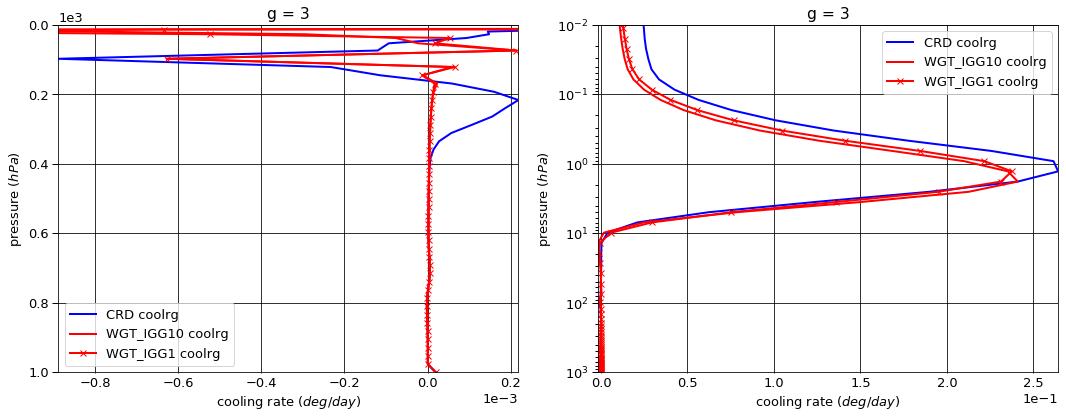

# Figure: cooling rate g-group 4

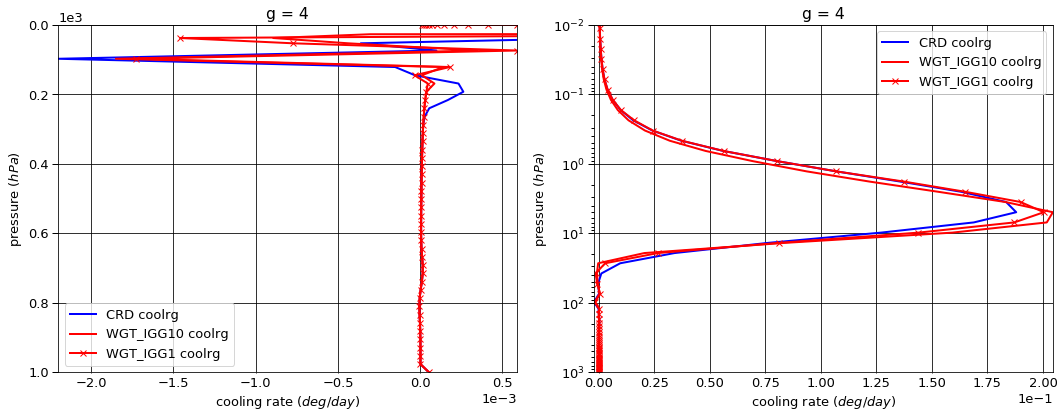

# Figure: cooling rate g-group 5

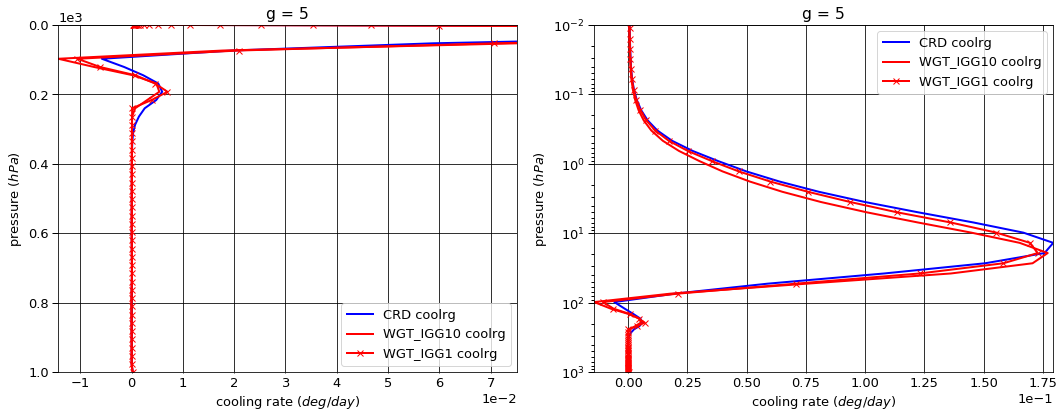

# Figure: cooling rate g-group 6

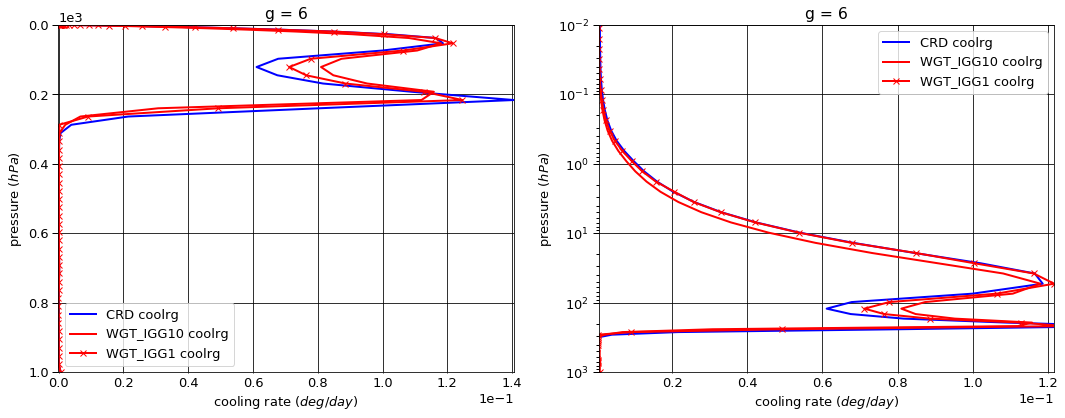

# Figure: cooling rate g-group 7

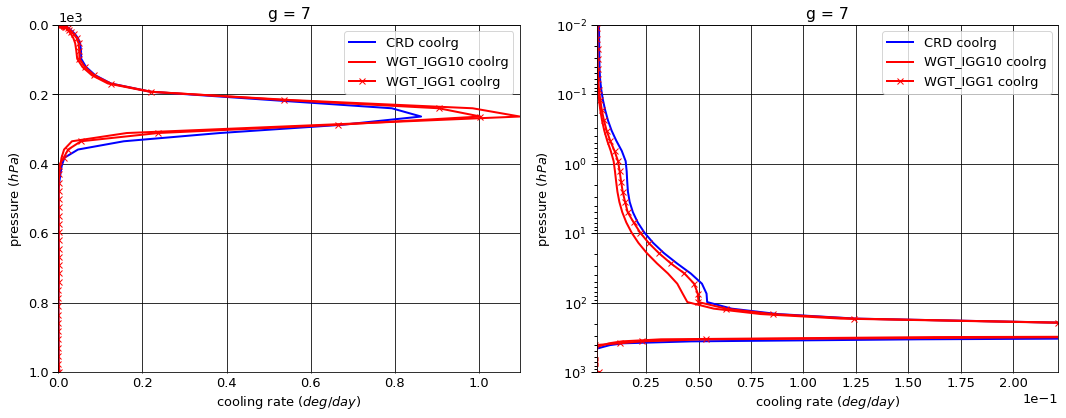

# Figure: cooling rate g-group 8

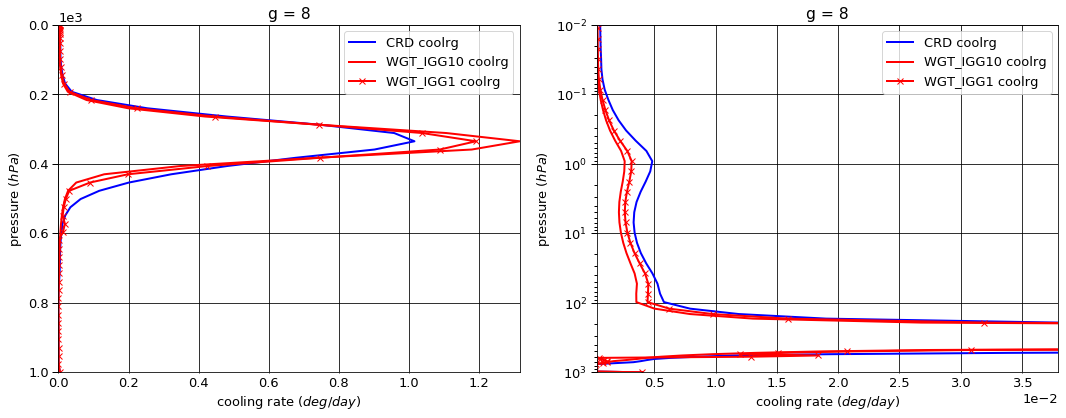

# Figure: cooling rate g-group 9

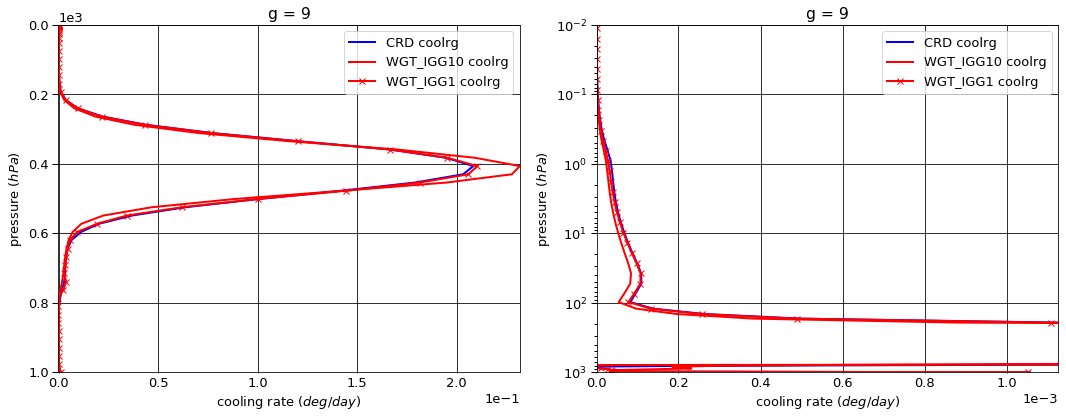

# Figure: cooling rate g-group total

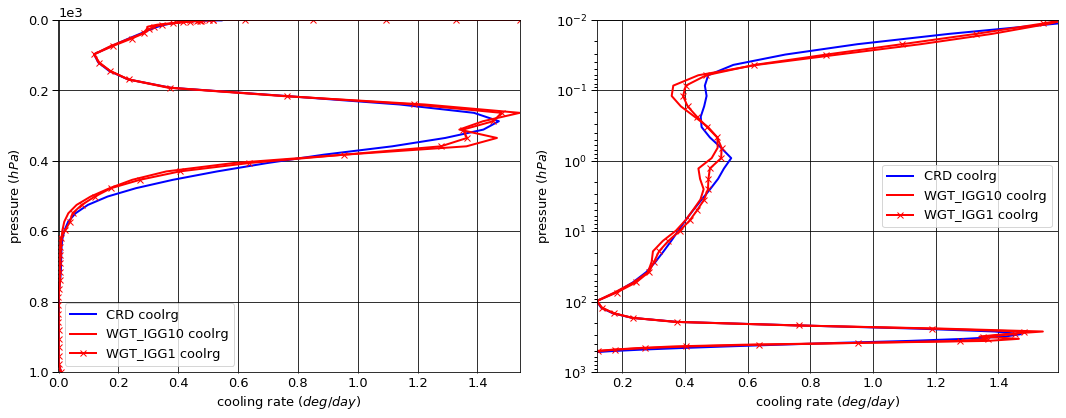

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007666   0.000000  -0.007666
  1013.0   76     -0.013228   0.013223  -0.000005
2 0.0      1      -0.032249   0.000000  -0.032249
  1013.0   76     -0.044835   0.044818  -0.000017
3 0.0      1      -0.108858   0.000000  -0.108858
  1013.0   76     -0.143468   0.143414  -0.000054
4 0.0      1      -0.271453   0.000000  -0.271453
  1013.0   76     -0.398469   0.398321  -0.000147
5 0.0      1      -0.944609   0.000000  -0.944609
  1013.0   76     -1.628169   1.627563  -0.000606
6 0.0      1      -2.761541   0.000000  -2.761541
  1013.0   76     -5.068828   5.066951  -0.001877
7 0.0      1     -11.743549   0.000000 -11.743549
  1013.0   76    -18.993213  18.986124  -0.007089
8 0.0      1     -18.396134   0.000000 -18.396134
  1013.0   76    -27.381449  27.370281  -0.011167
9 0.0      1      -4.604021   0.000000  -4.604021
  1013.0   76     -6.553475   6.550546  -0.002929


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007527   0.000000  -0.007527
  1013.0   76     -0.013228   0.013223  -0.000005
2 0.0      1      -0.033036   0.000000  -0.033036
  1013.0   76     -0.044835   0.044818  -0.000017
3 0.0      1      -0.109028   0.000000  -0.109028
  1013.0   76     -0.143468   0.143414  -0.000054
4 0.0      1      -0.273805   0.000000  -0.273805
  1013.0   76     -0.398469   0.398321  -0.000147
5 0.0      1      -0.940562   0.000000  -0.940562
  1013.0   76     -1.628169   1.627563  -0.000606
6 0.0      1      -2.693077   0.000000  -2.693077
  1013.0   76     -5.068828   5.066951  -0.001877
7 0.0      1     -11.652728   0.000000 -11.652728
  1013.0   76    -18.993213  18.986124  -0.007089
8 0.0      1     -18.262591   0.000000 -18.262591
  1013.0   76    -27.381449  27.370281  -0.011167
9 0.0      1      -4.596721   0.000000  -4.596721
  1013.0   76     -6.553475   6.550555  -0.002920


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007553   0.000000  -0.007553
  1013.0   76     -0.013228   0.013223  -0.000005
2 0.0      1      -0.032959   0.000000  -0.032959
  1013.0   76     -0.044835   0.044818  -0.000017
3 0.0      1      -0.108657   0.000000  -0.108657
  1013.0   76     -0.143468   0.143414  -0.000054
4 0.0      1      -0.273650   0.000000  -0.273650
  1013.0   76     -0.398469   0.398321  -0.000147
5 0.0      1      -0.939908   0.000000  -0.939908
  1013.0   76     -1.628169   1.627563  -0.000606
6 0.0      1      -2.716380   0.000000  -2.716380
  1013.0   76     -5.068828   5.066951  -0.001877
7 0.0      1     -11.650115   0.000000 -11.650115
  1013.0   76    -18.993213  18.986124  -0.007089
8 0.0      1     -18.272001   0.000000 -18.272001
  1013.0   76    -27.381449  27.370281  -0.011167
9 0.0      1      -4.601886   0.000000  -4.601886
  1013.0   76     -6.553475   6.550555  -0.002920


WGT_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      1.389847e-04  0.000000e+00  0.000139
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
2 0.0      1     -7.861900e-04  0.000000e+00 -0.000786
  1013.0   76     0.000000e+00  6.938894e-18  0.000000
3 0.0      1     -1.702300e-04  0.000000e+00 -0.000170
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
4 0.0      1     -2.351200e-03  0.000000e+00 -0.002351
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
5 0.0      1      4.047520e-03  0.000000e+00  0.004048
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
6 0.0      1      6.846410e-02  0.000000e+00  0.068464
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
7 0.0      1      9.082100e-02  0.000000e+00  0.090821
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
8 0.0      1      1.335430e-01  0.000000e+00  0.133543
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
9 0.0      1      7.300100e-03  0.000000e+00  0.007300
  1013.0   76     8.881784e-16  9.100000e-06  0.000009


WGT_IGG1 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      1.122738e-04  0.000000e+00  0.000112
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
2 0.0      1     -7.097830e-04  0.000000e+00 -0.000710
  1013.0   76     0.000000e+00  6.938894e-18  0.000000
3 0.0      1      2.014500e-04  0.000000e+00  0.000201
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
4 0.0      1     -2.196610e-03  0.000000e+00 -0.002197
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
5 0.0      1      4.701080e-03  0.000000e+00  0.004701
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
6 0.0      1      4.516110e-02  0.000000e+00  0.045161
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
7 0.0      1      9.343400e-02  0.000000e+00  0.093434
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
8 0.0      1      1.241330e-01  0.000000e+00  0.124133
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
9 0.0      1      2.135600e-03  0.000000e+00  0.002136
  1013.0   76     8.881784e-16  9.100000e-06  0.000009

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      3.956973
  1001.112500 75     0.000002
2 0.000312    1      0.349807
  1001.112500 75     0.000006
3 0.000312    1      0.019599
  1001.112500 75     0.000019
4 0.000312    1      0.000011
  1001.112500 75     0.000053
5 0.000312    1      0.000413
  1001.112500 75     0.000218
6 0.000312    1      0.000644
  1001.112500 75     0.000676
7 0.000312    1      0.002202
  1001.112500 75     0.002553
8 0.000312    1      0.000470
  1001.112500 75     0.004020
9 0.000312    1      0.000001
  1001.112500 75     0.001055


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.816691e+00
  1001.112500 75     1.755804e-06
2 0.000312    1      1.204663e-01
  1001.112500 75     6.116567e-06
3 0.000312    1      8.002862e-03
  1001.112500 75     1.944880e-05
4 0.000312    1      1.016524e-05
  1001.112500 75     5.304353e-05
5 0.000312    1      3.194194e-04
  1001.112500 75     2.180981e-04
6 0.000312    1      3.202040e-04
  1001.112500 75     6.759234e-04
7 0.000312    1      1.239295e-03
  1001.112500 75     2.552765e-03
8 0.000312    1      2.394694e-04
  1001.112500 75     4.020226e-03
9 0.000312    1      7.281623e-07
  1001.112500 75     1.050983e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.156287e+00
  1001.112500 75     1.755804e-06
2 0.000312    1      1.587215e-01
  1001.112500 75     6.116567e-06
3 0.000312    1      9.429302e-03
  1001.112500 75     1.944880e-05
4 0.000312    1      1.157434e-05
  1001.112500 75     5.304353e-05
5 0.000312    1      3.658526e-04
  1001.112500 75     2.180981e-04
6 0.000312    1      3.772378e-04
  1001.112500 75     6.759234e-04
7 0.000312    1      1.542855e-03
  1001.112500 75     2.552765e-03
8 0.000312    1      3.020646e-04
  1001.112500 75     4.020226e-03
9 0.000312    1      9.444772e-07
  1001.112500 75     1.050983e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.140282e+00
  1001.112500 75     2.117582e-22
2 0.000312    1     -2.293404e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.159564e-02
  1001.112500 75     3.388132e-21
4 0.000312    1     -9.748810e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -9.345021e-05
  1001.112500 75     2.710505e-20
6 0.000312    1     -3.234867e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.622466e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -2.308002e-04
  1001.112500 75     0.000000e+00
9 0.000312    1     -4.915657e-07
  1001.112500 75    -4.194700e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.800686e+00
  1001.112500 75     2.117582e-22
2 0.000312    1     -1.910851e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.016921e-02
  1001.112500 75     3.388132e-21
4 0.000312    1      4.342260e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -4.701702e-05
  1001.112500 75     2.710505e-20
6 0.000312    1     -2.664528e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -6.586868e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.682049e-04
  1001.112500 75     0.000000e+00
9 0.000312    1     -2.752509e-07
  1001.112500 75    -4.194700e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.870081,0.000000,-38.870081
1013.0,76,-60.225134,60.201242,-0.023892



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.569074,0.000000,-38.569074
1013.0,76,-60.225134,60.201251,-0.023883



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.603109,0.000000,-38.603109
1013.0,76,-60.225134,60.201251,-0.023883



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.301007,0.000000,0.301007
1013.0,76,0.000000,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.266972,0.000000,0.266972
1013.0,76,0.000000,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.330118
1001.112500,75,0.008603



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,1.947289
1001.112500,75,0.008598



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.327038
1001.112500,75,0.008598



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.382829
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.003080
1001.112500,75,-0.000004


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000279,0.000225
2,0.000838,0.000756
3,0.002750,0.002425
4,0.008250,0.006779
5,0.032956,0.027640
6,0.105132,0.086193
7,0.378838,0.322063
8,0.391471,0.449921
9,0.079485,0.103997


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.632043e-22


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000279,0.000225,0.000279,0.000225,1.0
2,5.686282e-18,0.078727,0.000838,0.000756,0.001118,0.000981,1.0
3,4.476633e-19,0.078727,0.002750,0.002425,0.003868,0.003407,1.0
4,1.008726e-18,2.253314,0.008250,0.006779,0.012118,0.010186,30.0
5,8.035412e-20,0.079659,0.032956,0.027640,0.045074,0.037826,30.0
6,6.290914e-20,0.782899,0.105132,0.086193,0.150206,0.124019,300.0
7,5.055345e-21,0.080359,0.378838,0.322063,0.529044,0.446082,300.0
8,4.062448e-22,0.080359,0.391471,0.449921,0.920515,0.896003,300.0
9,1.632043e-22,0.401739,0.079485,0.103997,1.000000,1.000000,300.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.391628e-16  1.084005e-16   3.128792  1.229078e-02
      2 0.000312     1.027515e-17  3.454622e-18   2.974320  3.806179e-04
      3 0.000312     2.390040e-19  7.040263e-20   3.394817  8.371232e-06
      4 0.000312     4.279683e-23  4.279300e-23   1.000090  2.961074e-09
      5 0.000312     3.599925e-22  2.151628e-22   1.673117  1.789423e-08
      6 0.000312     1.438056e-22  4.626482e-23   3.108315  5.225976e-09
      7 0.000312     1.459776e-22  1.461386e-23   9.988980  6.464887e-09
      8 0.000312     2.811311e-23  1.130168e-24  24.875153  1.198426e-09
      9 0.000312     4.231435e-25  1.938373e-25   2.182983  2.293216e-11
2     1 0.000750     3.397641e-16  1.086616e-16   3.126810  4.960680e-03
      2 0.000750     1.033025e-17  3.470189e-18   2.976855  1.540722e-04
      3 0.000750     2.403756e-19  7.124762e-20   3.373806  3.399774e-06
      4 0.000750     9.501402e-23  9.500771e-23   1.000066  2.647936e-09
      5 0.000750     3.668913e-22  2.208229e-22   1.661473  7.375664e-09
      6 0.000750     1.442259e-22  4.674076e-23   3.085655  2.117753e-09
      7 0.000750     1.464153e-22  1.470214e-23   9.958781  2.612275e-09
      8 0.000750     2.826316e-23  1.138074e-24  24.834198  4.853071e-10
      9 0.000750     4.264684e-25  1.953381e-25   2.183232  9.309098e-12
3     1 0.001052     3.409726e-16  1.090890e-16   3.125635  6.982653e-03
      2 0.001052     1.043735e-17  3.492998e-18   2.988076  2.179484e-04
      3 0.001052     2.425265e-19  7.222537e-20   3.357913  4.819765e-06
      4 0.001052     1.311984e-22  1.311892e-22   1.000071  5.127605e-09
      5 0.001052     3.749086e-22  2.263225e-22   1.656524  1.058800e-08
      6 0.001052     1.446776e-22  4.727267e-23   3.060492  2.989755e-09
      7 0.001052     1.472573e-22  1.482250e-23   9.934714  3.685043e-09
      8 0.001052     2.856604e-23  1.148929e-24  24.863180  6.878602e-10
      9 0.001052     4.328318e-25  1.978814e-25   2.187329  1.324393e-11
4     1 0.001476     3.421945e-16  1.095424e-16   3.123854  9.833408e-03
      2 0.001476     1.054777e-17  3.517816e-18   2.998387  3.085271e-04
      3 0.001476     2.448698e-19  7.336735e-20   3.337586  6.843988e-06
      4 0.001476     1.819461e-22  1.819311e-22   1.000082  9.975839e-09
      5 0.001476     3.843481e-22  2.331283e-22   1.648655  1.527031e-08
      6 0.001476     1.452234e-22  4.790387e-23   3.031560  4.227509e-09
      7 0.001476     1.481377e-22  1.495649e-23   9.904576  5.201619e-09
      8 0.001476     2.887824e-23  1.161031e-24  24.872918  9.755302e-10
      9 0.001476     4.394718e-25  2.005971e-25   2.190818  1.885782e-11
5     1 0.002070     3.434135e-16  1.100246e-16   3.121243  1.384629e-02
      2 0.002070     1.066053e-17  3.545113e-18   3.007106  4.368071e-04
      3 0.002070     2.474362e-19  7.472712e-20   3.311196  9.731701e-06
      4 0.002070     2.531342e-22  2.531082e-22   1.000103  1.946619e-08
      5 0.002070     3.956560e-22  2.417136e-22   1.636879  2.214102e-08
      6 0.002070     1.458945e-22  4.866698e-23   2.997812  5.986013e-09
      7 0.002070     1.490505e-22  1.510772e-23   9.865844  7.342495e-09
      8 0.002070     2.919610e-23  1.174707e-24  24.853933  1.383354e-09
      9 0.002070     4.463455e-25  2.035004e-25   2.193340  2.685622e-11
6     1 0.002904     3.446296e-16  1.105469e-16   3.117497  1.950152e-02
      2 0.002904     1.077618e-17  3.575894e-18   3.013562  6.187931e-04
      3 0.002904     2.503023e-19  7.639073e-20   3.276605  1.386941e-05
      4 0.002904     3.530127e-22  3.529652e-22   1.000135  3.807915e-08
      5 0.002904     4.095500e-22  2.527881e-22   1.620132  3.234399e-08
      6 0.002904     1.467389e-22  4.961352e-23   2.957639  8.495613e-09
      7 0.002904     1.500024e-22  1.528298e-23   9.814996  1.036878e-08
      8 0.002904     2.952010e-23  1.190565e-24  24.795028  1.962139e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
